In [1]:
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.cluster import KMeans
from sklearn import manifold

from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
orderdf = pd.read_csv('ignored_assets/orders.csv', parse_dates = [6,7])

In [3]:
coredf = orderdf[orderdf['dest_district_hash'].isin(orderdf['start_district_hash'].unique())]

In [4]:
dtable = pd.pivot_table(coredf, index=['start_district_hash'], 
                        columns=['dest_district_hash'], aggfunc=[np.mean],
                       values=['expected_travel_time'])

In [5]:
dtable.to_csv('travel_time.csv')

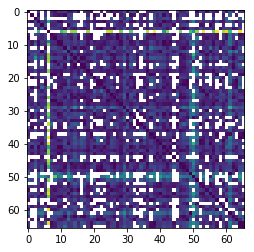

In [6]:
plt.imshow(dtable.as_matrix())

In [7]:
dtable

mean  \
                                             expected_travel_time   
dest_district_hash               08232402614a9b48895cc3d0aeb0e9f2   
start_district_hash                                                 
08232402614a9b48895cc3d0aeb0e9f2                         3.708321   
08f5b445ec6b29deba62e6fd8b0325a6                              NaN   
0a5fef95db34383403d11cb6af937309                              NaN   
1afd7afbc81ecc1b13886a569d869e8a                        29.357642   
1c60154546102e6525f68cb4f31e0657                              NaN   
1cbfbdd079ef93e74405c53fcfff8567                        33.491041   
1ecbb52d73c522f184a6fc53128b1ea1                              NaN   
2301bc920194c95cf0c7486e5675243c                        24.228781   
2350be163432e42270d2670cb3c02f80                        14.533159   
2407d482f0ffa22a947068f2551fe62c                        35.279205   
2920ece99323b4c111d6f9affc7ea034                        32.144838   
307afa4120c590b3a46cf4ff5415608a                        38.570531   
364bf755f9b270f0f9141d1a61de43ee                        38.586084   
38d5ad2d22b61109fd8e7b43cd0e8901                        15.041720   
3a43dcdff3c0b66b1acb1644ff055f9d                        40.281321   
3e12208dd0be281c92a6ab57d9a6fb32                         9.040270   
445ff793ebd3477d4a2e0b36b2db9271                              NaN   
44c097b7bd219d104050abbafe51bd49                        31.564070   
4725c39a5e5f4c188d382da3910b3f3f                        22.042247   
49ac89aa860c27e26c0836cb8dab2df2                        17.093758   
4b7f6f4e2bf237b6cc58f57142bea5c0                              NaN   
4b9e4cf2fbdc8281b8a1f9f12b80ce4d                              NaN   
4f4041f7db0c7f69892d9b74c1a7efa1                              NaN   
4f8d81b5c31af5d1ba579a65ddc8a5cb                        47.124480   
52a4e8aaa12f70020e889aed8fd5ddbc                        32.953439   
52d7b69796362a8ed1691a6cc02ddde4                         8.015032   
52e56004d92b8c74d53e1e42699cba6f                        23.901287   
58c7a4888306d8ff3a641d1c0feccbe3                        21.073819   
62afaf3288e236b389af9cfdc5206415                        28.628920   
693a21b16653871bbd455403da5412b4                        59.773955   
...                                                           ...   
82cc4851f9e4faa4e54309f8bb73fd7c                        21.191075   
8316146a6f78cc6d9f113f0390859417                        17.730002   
87285a66236346350541b8815c5fae94                        34.022437   
8bb37d24db1ad665e706c2655d9c4c72                              NaN   
90c5a34f06ac86aee0fd70e2adce7d8a                        43.718453   
91690261186ae5bee8f83808ea1e4a01                        43.601808   
929ec6c160e6f52c20a4217c7978f681                        29.280678   
a5609739c6b5c2719a3752327c5e33a7                        44.791585   
a735449c5c09df639c35a7d61fad3ee5                              NaN   
a814069db8d32f0fa6e188f41059c6e1                              NaN   
b05379ac3f9b7d99370d443cfd5dcc28                        22.677637   
b26a240205c852804ff8758628c0a86a                        26.361714   
b702e920dcd2765e624dc1ce3a770512                        52.402655   
ba32abfc048219e933bee869741da911                        71.853167   
bf44d327f0232325c6d5280926d7b37d                              NaN   
c4ec24e0a58ebedaa1661e5c09e47bb5                        70.608957   
c9f855e3e13480aad0af64b418e810c3                              NaN   
ca064c2682ca48c6a21de012e87c0df5                        36.631118   
cb6041cc08444746caf6039d8b9e43cb                         8.109252   
d05052b4bda7662a084f235e880f50fa                        42.272058   
d4ec2125aff74eded207d2d915ef682f                        27.121922   
d524868ce69cb9db10fc5af177fb9423                        13.434433   
d5cb17978de290c56e84c9cf97e63186                              NaN   
dd8d3b9665536d6e05b29c2648c0e69a                        49.

In [8]:
dmatrix = dtable.as_matrix()

dmatrix_nonan = dmatrix

#Obtain mean of columns as you need, nanmean is just convenient.
col_mean = np.nanmean(dmatrix,axis=0)

#Find indicies that you need to replace
inds = np.where(np.isnan(dmatrix))

#Place column means in the indices. Align the arrays using take
dmatrix_nonan[inds]=np.take(col_mean,inds[1])

D = (dmatrix_nonan + dmatrix_nonan.T) / 2

In [9]:
mds = manifold.MDS(n_components=2, max_iter=30000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(D).embedding_

That's the mean travel time between known OD-pairs. Unlike the previous case, we are going to:
- Use Linear Regression to find the missing OD distances
- Measure distances in _time_

### A Regression Approach

In [10]:
N = len(dtable.index)

In [11]:
X = np.zeros((len(dtable.index), 2), dtype=np.float64)

In [12]:
dtable2 = pd.pivot_table(coredf, index=['start_district_hash'], 
                        columns=['dest_district_hash'], aggfunc=[len],
                       values=['expected_travel_time'])

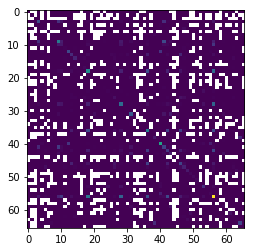

In [13]:
plt.imshow(dtable2)

In [15]:
def fake_len(x):
    #print coredf.ix[x.index[0]]
    #raise Exception
    return tuple(x)

In [16]:
dtable3 = pd.pivot_table(coredf, index=['start_district_hash'], 
                        columns=['dest_district_hash'], aggfunc=[fake_len],
                       values=['expected_travel_time']).as_matrix()

In [17]:
C = 1 / float(len(coredf))

In [18]:
def loss(x):
    
    l = 0
    lprime = np.zeros(len(x), dtype=np.float64)
    
    for i in range(N):
        xi = x[2 * i]
        yi = x[2 * i + 1]
        for j in range(N):
            xj = x[2 * j] 
            yj = x[2 * j + 1]
            if dtable3[i][j]:
                #for dijk in dtable3[i][j]:
                    dijk = np.array(dtable3[i][j])
                    squaredDistance = (xj - xi) * (xj - xi) + (yj - yi) * (yj - yi)
                    distance = np.sqrt(squaredDistance)
                    delta = squaredDistance - dijk * dijk
                
                    l += (delta * delta).sum() * C
                
                    lprime[2*i]     += 4 * delta.sum() * (xi - xj) * C
                    lprime[2*i + 1] += 4 * delta.sum() * (yi - yj) * C

                    lprime[2*j]     += 4 * delta.sum() * (xj - xi) * C
                    lprime[2*j + 1] += 4 * delta.sum() * (yj - yi) * C
    print l
    
    return (l, lprime)

In [19]:
x = np.zeros(len(dtable.index)*2, dtype=np.float64)

for i in range(N):
    x[2*i:2*i+2,] = pos[i,:]

In [20]:
loss(x)

67942.2985948


(67942.298594822481,
 array([  2.75042543e+00,   5.68488090e+00,  -8.38952202e-01,
         -5.08311523e+00,  -6.40049604e-02,  -5.04735877e+00,
          1.95183535e+01,   5.71479818e+01,   3.71555564e+00,
         -2.32512047e+00,   2.50640335e+01,   1.92041405e+00,
         -1.80790871e+02,  -2.24276754e+02,   2.69572569e+01,
          5.32528812e+00,   6.47146693e+00,   8.35099822e+00,
          8.78728202e+01,   1.73303868e+02,  -2.87250406e+01,
          2.04846543e+00,   1.04946718e+01,   5.45047875e+00,
         -1.74517008e+00,   9.58590909e+00,  -5.46038013e+00,
         -1.28385663e+02,   1.90067884e+01,  -6.56236905e+00,
          8.65850450e+00,   1.26663996e+01,  -3.04412513e+00,
          2.74789213e+00,   8.26886395e+00,   4.85780385e+00,
         -2.42059452e+01,  -6.34227618e+01,   7.58130416e+00,
          1.60817594e+00,   6.84509635e-01,  -4.21501113e+00,
         -7.19121426e+00,   2.59849106e-01,  -1.45420399e+00,
          3.58252216e+00,  -1.36552984e-02,   4.5

In [21]:
res = minimize(loss, x, method='CG', jac=True)

67942.2985948
67942.2985948
67435.5682279
65789.1625958
64030.4963237
61100.6796561
59530.6751909
59035.8718229
57269.5503128
55591.2305581
59400.5395052
55160.5951097
55112.7663176
54936.3454565
54728.9839538
54612.7063377
54582.0491133
54410.201039
54355.1939667
54305.4410097
54218.6876747
54104.1236603
54071.2764608
54037.3174231
54017.1582099
53997.4982994
53975.5184391
53970.0594984
53932.4434316
53904.4518695
53889.0901459
53885.191821
53855.970008
53845.9117677
53842.6489913
53824.9820464
53799.1026652
53783.6466261
53780.8165221
53775.0619657
53759.3710774
53730.3713129
53740.7587541
53710.3706561
53695.2863026
53674.0612984
53652.3812651
53644.1242172
53638.7529779
53628.9731674
53616.904008
53597.3972339
53586.8623975
53560.3425095
53527.820883
53496.2365691
53560.9639153
53488.4155944
53481.7421585
53472.9455354
53465.5238321
53462.9697661
53460.9960881
53453.7374048
53449.8192837
53439.2577732
53424.6426502
53412.8688315
53440.5401271
53410.0865175
53405.2619939
53400.06994

53214.1929326
53214.1932446
53214.1928821
53214.1928026
53214.1927668
53214.1925727
53214.192417
53214.1920506
53214.1917114
53214.1915029
53214.1911979
53214.1911212
53214.1905336
53214.1903111
53214.1901928
53214.1898701
53214.1893408
53214.1891125
53214.1890009
53214.1886625
53214.1882961
53214.1880348
53214.1879666
53214.1878833
53214.187689
53214.1875864
53214.1875562
53214.1874893
53214.1874669
53214.1873227
53214.1872426
53214.186977
53214.1867929
53214.1867506
53214.186688
53214.1865187
53214.1864245
53214.1863861
53214.1862811
53214.1861597
53214.1860775
53214.1859719
53214.1858899
53214.1858519
53214.1858361
53214.1857959
53214.1858187
53214.1857801
53214.185758
53214.1857442
53214.1857294
53214.1857037
53214.1856778
53214.18563
53214.185568
53214.1854827
53214.1854356
53214.1854235
53214.1853277
53214.1852737
53214.184986
53214.1841294
53214.1837201
53214.1828157
53214.1826179
53214.1813877
53214.1801011
53214.1784467
53214.179625
53214.1778291
53214.1775048
53214.1774076
53

53214.1676435
53214.1676436
53214.1676435
53214.1676434
53214.1676436
53214.1676434
53214.1676434
53214.1676434
53214.1676434
53214.1676433
53214.1676433
53214.1676433
53214.1676433
53214.1676433
53214.1676433
53214.1676433
53214.1676432
53214.1676432
53214.1676432
53214.1676432
53214.1676432
53214.1676432
53214.1676432
53214.1676431
53214.1676431
53214.1676431
53214.167643
53214.1676432
53214.167643
53214.167643
53214.167643
53214.167643
53214.167643
53214.167643
53214.1676429
53214.1676429
53214.1676429
53214.1676429
53214.1676429
53214.1676428
53214.1676428
53214.1676428
53214.1676428
53214.1676428
53214.1676428
53214.1676428
53214.1676428
53214.1676427
53214.1676427
53214.1676427
53214.1676427
53214.1676427
53214.1676427
53214.1676427
53214.1676427
53214.1676427
53214.1676427
53214.1676427
53214.1676427
53214.1676426
53214.1676426
53214.1676426
53214.1676426
53214.1676426
53214.1676425
53214.1676425
53214.1676424
53214.1676424
53214.1676424
53214.1676424
53214.1676424
53214.1676424

53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398
53214.1676398


In [24]:
pos2 = np.zeros(pos.shape,dtype=np.float64)

In [25]:
for i in range(N):
    pos2[i,:] = res.x[2*i:2*i+2,]

In [26]:
posdf = pd.DataFrame(pos2, columns=['x','y'], index = dtable2.index)

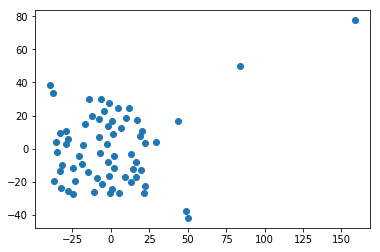

In [27]:
plt.scatter(pos2[:,0],pos2[:,1])

In [28]:
posdf.to_csv('inferred_locations.csv')

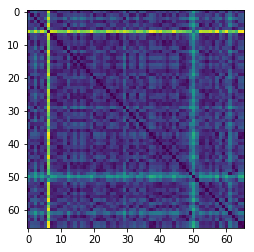

In [29]:
D2 = squareform(pdist(pos2))
plt.imshow(D2)

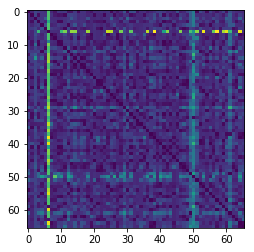

In [30]:
plt.imshow(dtable.as_matrix())

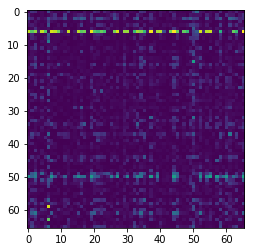

In [31]:
plt.imshow(np.abs(dtable.as_matrix() - D2));

In [32]:
np.nan_to_num(np.abs(dtable.as_matrix() - D2)).mean()

9.1650016012590321

This finishes the show!

In [33]:
D2.mean()

42.157738807360566

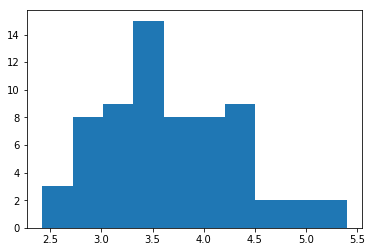

In [34]:
plt.hist(np.diag(dtable));

In [32]:
orderdf['expected_travel_time'].mean()

8.079615916294097

In [14]:
posdf

NameError: name 'posdf' is not defined

In [39]:
dstd = pd.pivot_table(coredf, index=['start_district_hash'], 
                        columns=['dest_district_hash'], aggfunc=[np.std],
                       values=['expected_travel_time'])

In [43]:
dstd

std  \
                                             expected_travel_time   
dest_district_hash               08232402614a9b48895cc3d0aeb0e9f2   
start_district_hash                                                 
08232402614a9b48895cc3d0aeb0e9f2                         3.380146   
08f5b445ec6b29deba62e6fd8b0325a6                              NaN   
0a5fef95db34383403d11cb6af937309                              NaN   
1afd7afbc81ecc1b13886a569d869e8a                        15.866069   
1c60154546102e6525f68cb4f31e0657                              NaN   
1cbfbdd079ef93e74405c53fcfff8567                         2.527377   
1ecbb52d73c522f184a6fc53128b1ea1                              NaN   
2301bc920194c95cf0c7486e5675243c                         2.976131   
2350be163432e42270d2670cb3c02f80                         2.947708   
2407d482f0ffa22a947068f2551fe62c                         3.882949   
2920ece99323b4c111d6f9affc7ea034                         7.825393   
307afa4120c590b3a46cf4ff5415608a                         2.480633   
364bf755f9b270f0f9141d1a61de43ee                         0.565697   
38d5ad2d22b61109fd8e7b43cd0e8901                         4.356696   
3a43dcdff3c0b66b1acb1644ff055f9d                         4.675677   
3e12208dd0be281c92a6ab57d9a6fb32                         3.089776   
445ff793ebd3477d4a2e0b36b2db9271                              NaN   
44c097b7bd219d104050abbafe51bd49                         5.524327   
4725c39a5e5f4c188d382da3910b3f3f                         4.906162   
49ac89aa860c27e26c0836cb8dab2df2                         4.009718   
4b7f6f4e2bf237b6cc58f57142bea5c0                              NaN   
4b9e4cf2fbdc8281b8a1f9f12b80ce4d                              NaN   
4f4041f7db0c7f69892d9b74c1a7efa1                              NaN   
4f8d81b5c31af5d1ba579a65ddc8a5cb                              NaN   
52a4e8aaa12f70020e889aed8fd5ddbc                         7.457435   
52d7b69796362a8ed1691a6cc02ddde4                         2.683649   
52e56004d92b8c74d53e1e42699cba6f                         6.979785   
58c7a4888306d8ff3a641d1c0feccbe3                         7.708680   
62afaf3288e236b389af9cfdc5206415                        12.331299   
693a21b16653871bbd455403da5412b4                         8.308659   
...                                                           ...   
82cc4851f9e4faa4e54309f8bb73fd7c                         5.096115   
8316146a6f78cc6d9f113f0390859417                              NaN   
87285a66236346350541b8815c5fae94                         5.437173   
8bb37d24db1ad665e706c2655d9c4c72                              NaN   
90c5a34f06ac86aee0fd70e2adce7d8a                         1.663536   
91690261186ae5bee8f83808ea1e4a01                        10.920391   
929ec6c160e6f52c20a4217c7978f681                         7.118015   
a5609739c6b5c2719a3752327c5e33a7                         2.424416   
a735449c5c09df639c35a7d61fad3ee5                              NaN   
a814069db8d32f0fa6e188f41059c6e1                              NaN   
b05379ac3f9b7d99370d443cfd5dcc28                         6.839916   
b26a240205c852804ff8758628c0a86a                         7.319857   
b702e920dcd2765e624dc1ce3a770512                        34.933594   
ba32abfc048219e933bee869741da911                              NaN   
bf44d327f0232325c6d5280926d7b37d                              NaN   
c4ec24e0a58ebedaa1661e5c09e47bb5                        16.111057   
c9f855e3e13480aad0af64b418e810c3                              NaN   
ca064c2682ca48c6a21de012e87c0df5                         6.900272   
cb6041cc08444746caf6039d8b9e43cb                         3.016869   
d05052b4bda7662a084f235e880f50fa                              NaN   
d4ec2125aff74eded207d2d915ef682f                         8.608044   
d524868ce69cb9db10fc5af177fb9423                         2.656119   
d5cb17978de290c56e84c9cf97e63186                              NaN   
dd8d3b9665536d6e05b29c2648c0e69a                         0.1

In [44]:
dtable

mean  \
                                             expected_travel_time   
dest_district_hash               08232402614a9b48895cc3d0aeb0e9f2   
start_district_hash                                                 
08232402614a9b48895cc3d0aeb0e9f2                         3.708321   
08f5b445ec6b29deba62e6fd8b0325a6                        32.565244   
0a5fef95db34383403d11cb6af937309                        32.565244   
1afd7afbc81ecc1b13886a569d869e8a                        29.357642   
1c60154546102e6525f68cb4f31e0657                        32.565244   
1cbfbdd079ef93e74405c53fcfff8567                        33.491041   
1ecbb52d73c522f184a6fc53128b1ea1                        32.565244   
2301bc920194c95cf0c7486e5675243c                        24.228781   
2350be163432e42270d2670cb3c02f80                        14.533159   
2407d482f0ffa22a947068f2551fe62c                        35.279205   
2920ece99323b4c111d6f9affc7ea034                        32.144838   
307afa4120c590b3a46cf4ff5415608a                        38.570531   
364bf755f9b270f0f9141d1a61de43ee                        38.586084   
38d5ad2d22b61109fd8e7b43cd0e8901                        15.041720   
3a43dcdff3c0b66b1acb1644ff055f9d                        40.281321   
3e12208dd0be281c92a6ab57d9a6fb32                         9.040270   
445ff793ebd3477d4a2e0b36b2db9271                        32.565244   
44c097b7bd219d104050abbafe51bd49                        31.564070   
4725c39a5e5f4c188d382da3910b3f3f                        22.042247   
49ac89aa860c27e26c0836cb8dab2df2                        17.093758   
4b7f6f4e2bf237b6cc58f57142bea5c0                        32.565244   
4b9e4cf2fbdc8281b8a1f9f12b80ce4d                        32.565244   
4f4041f7db0c7f69892d9b74c1a7efa1                        32.565244   
4f8d81b5c31af5d1ba579a65ddc8a5cb                        47.124480   
52a4e8aaa12f70020e889aed8fd5ddbc                        32.953439   
52d7b69796362a8ed1691a6cc02ddde4                         8.015032   
52e56004d92b8c74d53e1e42699cba6f                        23.901287   
58c7a4888306d8ff3a641d1c0feccbe3                        21.073819   
62afaf3288e236b389af9cfdc5206415                        28.628920   
693a21b16653871bbd455403da5412b4                        59.773955   
...                                                           ...   
82cc4851f9e4faa4e54309f8bb73fd7c                        21.191075   
8316146a6f78cc6d9f113f0390859417                        17.730002   
87285a66236346350541b8815c5fae94                        34.022437   
8bb37d24db1ad665e706c2655d9c4c72                        32.565244   
90c5a34f06ac86aee0fd70e2adce7d8a                        43.718453   
91690261186ae5bee8f83808ea1e4a01                        43.601808   
929ec6c160e6f52c20a4217c7978f681                        29.280678   
a5609739c6b5c2719a3752327c5e33a7                        44.791585   
a735449c5c09df639c35a7d61fad3ee5                        32.565244   
a814069db8d32f0fa6e188f41059c6e1                        32.565244   
b05379ac3f9b7d99370d443cfd5dcc28                        22.677637   
b26a240205c852804ff8758628c0a86a                        26.361714   
b702e920dcd2765e624dc1ce3a770512                        52.402655   
ba32abfc048219e933bee869741da911                        71.853167   
bf44d327f0232325c6d5280926d7b37d                        32.565244   
c4ec24e0a58ebedaa1661e5c09e47bb5                        70.608957   
c9f855e3e13480aad0af64b418e810c3                        32.565244   
ca064c2682ca48c6a21de012e87c0df5                        36.631118   
cb6041cc08444746caf6039d8b9e43cb                         8.109252   
d05052b4bda7662a084f235e880f50fa                        42.272058   
d4ec2125aff74eded207d2d915ef682f                        27.121922   
d524868ce69cb9db10fc5af177fb9423                        13.434433   
d5cb17978de290c56e84c9cf97e63186                        32.565244   
dd8d3b9665536d6e05b29c2648c0e69a                        49.